In [0]:
np.random.seed(5151)
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, GRU, Activation, Conv1D, MaxPooling1D, Flatten,ConvLSTM2D
from keras.layers import Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from matplotlib import pyplot as plt

In [487]:
url='https://raw.githubusercontent.com/NayantaraPrem/EthereumPricePrediction/master/final_dataset.csv'
df = pd.read_csv(url)
df.head(4)

,Date(UTC),UnixTimeStamp,BlockSize,AvgGasPrices,GasUsed,GasLimit,BlockTime,NetworkUtilization,TransactionFees,BlockDifficulty,NetworkHash,EtherSupply,MarketCap,AddressCount,Price,EthereumGTrends,TweetCount,from_tx_count_dbbf,fromSum_dbbf,from_tx_count_92fe,fromSum_92fe,from_tx_count_fdc0,fromSum_fdc0,from_tx_count_5fc7,fromSum_5fc7,from_tx_count_8258,fromSum_8258,from_tx_count_f0be,fromSum_f0be,from_tx_count_aced,fromSum_aced,from_tx_count_ab89,fromSum_ab89,from_tx_count_769c,fromSum_769c,from_tx_count_a413,fromSum_a413,from_tx_count_6853,fromSum_6853,from_tx_count_92ff,fromSum_92ff,from_tx_count_fb32,fromSum_fb32,from_tx_count_84f3,fromSum_84f3,to_tx_count_dbbf,toSum_dbbf,to_tx_count_92fe,toSum_92fe,to_tx_count_e428,toSum_e428,to_tx_count_fdc0,toSum_fdc0,to_tx_count_5fc7,toSum_5fc7,to_tx_count_8258,toSum_8258,to_tx_count_f0be,toSum_f0be,to_tx_count_aced,toSum_aced,to_tx_count_ab89,toSum_ab89,to_tx_count_769c,toSum_769c,to_tx_count_a413,toSum_a413,to_tx_count_6853,toSum_6853,to_tx_count_92ff,toSum_92ff,to_tx_count_fb32,toSum_fb32,to_tx_count_84f3,toSum_84f3
0,2015-07-30,1438214400,644,0.0,0,0,4.46,0.0,0.0,0.121,11.5297,72049306.59,0.0,9205,0.0,0.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-07-31,1438300800,582,0.0,0,0,12.58,0.0,0.0,0.603,51.4594,72085498.31,0.0,9361,0.0,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-08-01,1438387200,575,0.0,0,0,16.34,0.0,0.0,0.887,57.7845,72113204.25,0.0,9476,0.0,0.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-08-02,1438473600,581,0.0,0,0,16.12,0.0,0.0,1.020,67.9224,72141427.69,0.0,9563,0.0,0.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [488]:
output_column = 'Price'
output_column_feature = 'Price'
X = df.drop(['Date(UTC)', 'UnixTimeStamp'], axis=1)

#drop rows with NaN values
X = X.fillna(0) 
features1 =['TransactionFees','AddressCount','EthereumGTrends','TweetCount']
# from_cols = [col for col in X.columns if 'from' in col]
# to_cols = [col for col in X.columns if 'to' in col]
features = features1 #+ ['toSum_84f3','fromSum_6853','from_tx_count_ab89','toSum_e428','to_tx_count_fdc0','toSum_fdc0','fromSum_fdc0','from_tx_count_8258','fromSum_ab89','fromSum_92ff','fromSum_92f2','from_tx_count_6853']
X['Price']=X['Price'].diff()
n_timesteps = 7
n_features = len(features)
n_outputs = 1 # no. of days to predict
N = len(X)
print(features)

['TransactionFees', 'AddressCount', 'EthereumGTrends', 'TweetCount']


In [489]:
train_split = 0.8 #20% test, 80% train
X_train = X[0:round(N*train_split)]
X_test = X[round(N*train_split):]
N_test = X_test.shape[0]
N_train = X_train.shape[0]
len(X_train)

1245

In [490]:
#scale training data
# input = 3 features. Column 4 shifted is output
input_scaler = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = pd.DataFrame(input_scaler.fit_transform(X_train), columns=X_train.columns)
output_scaler = MinMaxScaler(feature_range = (0, 1))
output_scaler.fit(np.array(X_train[output_column]).reshape((N_train,1))) # scaling the output column
X_train_scaled.head()

,BlockSize,AvgGasPrices,GasUsed,GasLimit,BlockTime,NetworkUtilization,TransactionFees,BlockDifficulty,NetworkHash,EtherSupply,MarketCap,AddressCount,Price,EthereumGTrends,TweetCount,from_tx_count_dbbf,fromSum_dbbf,from_tx_count_92fe,fromSum_92fe,from_tx_count_fdc0,fromSum_fdc0,from_tx_count_5fc7,fromSum_5fc7,from_tx_count_8258,fromSum_8258,from_tx_count_f0be,fromSum_f0be,from_tx_count_aced,fromSum_aced,from_tx_count_ab89,fromSum_ab89,from_tx_count_769c,fromSum_769c,from_tx_count_a413,fromSum_a413,from_tx_count_6853,fromSum_6853,from_tx_count_92ff,fromSum_92ff,from_tx_count_fb32,fromSum_fb32,from_tx_count_84f3,fromSum_84f3,to_tx_count_dbbf,toSum_dbbf,to_tx_count_92fe,toSum_92fe,to_tx_count_e428,toSum_e428,to_tx_count_fdc0,toSum_fdc0,to_tx_count_5fc7,toSum_5fc7,to_tx_count_8258,toSum_8258,to_tx_count_f0be,toSum_f0be,to_tx_count_aced,toSum_aced,to_tx_count_ab89,toSum_ab89,to_tx_count_769c,toSum_769c,to_tx_count_a413,toSum_a413,to_tx_count_6853,toSum_6853,to_tx_count_92ff,toSum_92ff,to_tx_count_fb32,toSum_fb32,to_tx_count_84f3,toSum_84f3
0,0.002084,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,NaN,0.0061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000211,0.0,0.0,0.0,0.314120,0.0,0.0,0.000134,0.000135,0.001132,0.0,0.000003,0.598674,0.0100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.459574,0.0,0.0,0.000212,0.000156,0.001999,0.0,0.000005,0.598674,0.0094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000181,0.0,0.0,0.0,0.451064,0.0,0.0,0.000249,0.000191,0.002882,0.0,0.000007,0.598674,0.0071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000362,0.0,0.0,0.0,0.460735,0.0,0.0,0.000279,0.000213,0.003758,0.0,0.000008,0.598674,0.0088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [491]:
# restructure data: model expects input data X to have shape : samples x timesteps x features
# samples = N - n_timesteps
# each sample is a n_timesteps x n_features matrix of data that is used to make a single prediction
# eg. 7 days worth of daily data if n_timesteps = 7 is used to predict the 8th day value
# Y should be samples x output dimensions
X_train_windows = []
y_train_windows = []
for i in range(N_train - n_timesteps):
    X_train_windows.append(np.array(X_train_scaled.loc[i:i+n_timesteps-1, features]))
    y_train_windows.append(np.array(X_train_scaled.loc[i+n_timesteps, X_train_scaled.columns == output_column]))

X_train_windows = np.array(X_train_windows)
y_train_windows = np.array(y_train_windows)
X_train_windows.shape, y_train_windows.shape

((1238, 7, 4), (1238, 1))

In [0]:
from keras.layers import RepeatVector
#define the model
model = Sequential()

model.add(LSTM(
    10,
    activation='relu',
    input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(1))
model.add(LSTM(10, activation='relu',return_sequences=True))
# model.add(Activation('softmax'))
# , activation='softmax',activity_regularizer= regularizers.l2(0.0001)
model.add(TimeDistributed(Dense(10, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae',metrics=['accuracy','binary_accuracy'])

# train model
y_train_windows = y_train_windows.reshape((y_train_windows.shape[0], y_train_windows.shape[1], 1))
history = model.fit(X_train_windows, y_train_windows, validation_split=0.33,epochs=100, verbose=0)


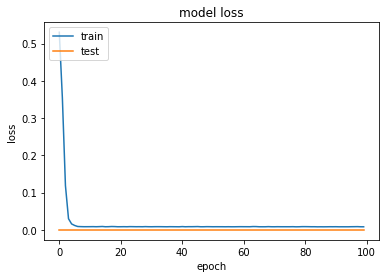

((304, 7, 4), (304, 1))

In [493]:
#print(history.history)
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#scale the input to [0,1]
X_test_scaled = pd.DataFrame(input_scaler.fit_transform(X_test), columns=X_test.columns)

#build the windows
X_test_windows = []
y_test_windows = []
for i in range(N_test - n_timesteps):
    X_test_windows.append(np.array(X_test_scaled.loc[i:i+n_timesteps-1, features]))
    y_test_windows.append(np.array(X_test_scaled.loc[i+n_timesteps, X_test_scaled.columns == output_column]))

X_test_windows = np.array(X_test_windows)
y_test_windows = np.array(y_test_windows)
X_test_windows.shape, y_test_windows.shape

In [0]:
#run predictions on each window
y_pred = []

for X_test_window in X_test_windows:
    y_pred.append(model.predict(X_test_window.reshape(1,n_timesteps,n_features))[0])
    
y_pred = np.array(y_pred)
y_pred = y_pred.reshape((y_pred.shape[0],y_pred.shape[1]))
# rescale the predictions back to the original values
y_pred_scaled = output_scaler.inverse_transform(y_pred)
y_actual_scaled = output_scaler.inverse_transform(y_test_windows)

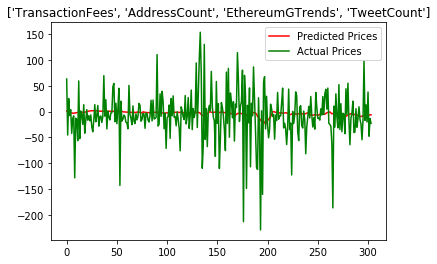

In [495]:
plt.plot(y_pred_scaled, color='red', label='Predicted Prices')
plt.plot(y_actual_scaled, color='green', label='Actual Prices')
plt.title(features1)
plt.legend()
plt.show()


In [496]:
def make_df(y_pred,y_true):
    y_pred.name = 'y_pred'
    y_true.name = 'y_true'
    
    df = pd.concat([y_pred,y_true],axis=1)

    df['sign_pred'] = df.y_pred.apply(np.sign)
    df['sign_true'] = df.y_true.apply(np.sign)
    df['is_correct'] = 0
    df.loc[df.sign_pred * df.sign_true > 0 ,'is_correct'] = 1 # only registers 1 when prediction was made AND it was correct
    df['is_incorrect'] = 0
    df.loc[df.sign_pred * df.sign_true < 0,'is_incorrect'] = 1 # only registers 1 when prediction was made AND it was wrong
    df['is_predicted'] = df.is_correct + df.is_incorrect
    df['result'] = df.sign_pred * df.y_true 
    return df
def calc_scorecard(df):
    scorecard = pd.Series()
    # building block metrics
    scorecard.loc['accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
    scorecard.loc['noise'] = df.y_pred.diff().abs().mean()

    # derived metrics
    scorecard.loc['y_true_chg'] = df.y_true.abs().mean()
    scorecard.loc['y_pred_chg'] = df.y_pred.abs().mean()
    scorecard.loc['prediction_calibration'] = scorecard.loc['y_pred_chg']/scorecard.loc['y_true_chg']
    scorecard.loc['capture_ratio'] = scorecard.loc['edge']/scorecard.loc['y_true_chg']*100

    # metrics for a subset of predictions
    scorecard.loc['edge_long'] = df[df.sign_pred == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_short'] = df[df.sign_pred == -1].result.mean()  - df.y_true.mean()

    scorecard.loc['edge_win'] = df[df.is_correct == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_lose'] = df[df.is_incorrect == 1].result.mean()  - df.y_true.mean()

    return scorecard
y_pred_scaled = y_pred_scaled.reshape(y_pred_scaled.shape[0])
y_actual_scaled = y_actual_scaled.reshape(y_actual_scaled.shape[0])
print(y_pred_scaled.shape)
df = make_df(pd.Series(y_pred_scaled),pd.Series(y_actual_scaled))

print(calc_scorecard(df))

(304,)
accuracy                  59.868421
edge                       7.796655
noise                      0.678923
y_true_chg                32.262370
y_pred_chg                 3.642474
prediction_calibration     0.112902
capture_ratio             24.166405
edge_long                  7.147663
edge_short                16.911589
edge_win                  41.446687
edge_lose                -22.491077
dtype: float64
